# Imports and Setup

Bagian ini memuat:
- Library inti (numpy/pandas) dan tooling (Path/joblib)
- Konfigurasi untuk skenario **GLOBAL** (userID hanya untuk grouping & split, bukan fitur)
- Utility untuk evaluasi metrik dan tuning threshold


In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
import joblib

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
)
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# =============================================================================
# 0) CONFIG
# =============================================================================
CANDIDATE_PATHS = [
    Path("../datasets/stress_forecast.csv"),
]
DATA_PATH = next((p for p in CANDIDATE_PATHS if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError("stress_forecast.csv not found. Check CANDIDATE_PATHS / DATA_PATH.")

MODEL_OUT = Path("../models/global_forecast.joblib")

DATE_COL   = "date"
USER_COL   = "userID"             # used only for split/grouping (never as features)
TARGET_COL = "stressLevel"    # 0..2

WINDOW   = 3
TEST_LEN = 12

# CV windows (relative index inside each user's train_pool), end exclusive
VAL_WINDOWS = [(12, 24), (18, 30)]

# Threshold search for decision rule from probabilities
THRESHOLDS = np.linspace(0.05, 0.95, 19)

# Blend config: p = alpha*p_ml + (1-alpha)*p_markov
USE_BLEND = True
ALPHAS = np.linspace(0.0, 1.0, 11)

RANDOM_STATE = 26

# Optional: add behavior lag1 if hour-like numeric columns exist
USE_BEHAVIOR_LAG1 = True


# =============================================================================
# Utilities
# =============================================================================
def eval_bin(y_true, y_pred):
    return {
        "acc": float(accuracy_score(y_true, y_pred)),
        "f1":  float(f1_score(y_true, y_pred, zero_division=0)),
    }

def tune_thr_from_proba(y_true, p_high, thresholds=THRESHOLDS):
    best_thr, best_f1 = None, -1.0
    for thr in thresholds:
        pred = (p_high >= thr).astype(int)
        f1 = float(f1_score(y_true, pred, zero_division=0))
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return float(best_thr), float(best_f1)

def safe_class_counts(y: np.ndarray):
    y = np.asarray(y).astype(int)
    return {0: int((y == 0).sum()), 1: int((y == 1).sum())}

def pick_existing_behavior_cols(df: pd.DataFrame):
    """
    Detect hour-like numeric columns for optional lag1 behavior features.
    This remains no-leak because shift(1) is applied during feature engineering.
    """
    exclude = {DATE_COL, USER_COL, TARGET_COL}
    numeric = [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]
    hour_like = [c for c in numeric if ("hour" in c.lower()) or ("hours" in c.lower())]

    known = [
        "studyHourPerDay",
        "sleepHourPerDay",
        "socialHourPerDay",
        "physicalActivityHourPerDay",
        "extracurricularHourPerDay",
    ]
    for c in known:
        if c in numeric and c not in hour_like:
            hour_like.append(c)

    return hour_like


# Load and Explore Dataset

Tujuan bagian ini:
- Load dataset dari `DATA_PATH`
- Validasi kolom penting: `date`, `userID`, `stressLevel`
- Sort per user berdasarkan waktu
- Deteksi `BEHAVIOR_COLS` (opsional) untuk fitur `lag1_*`


In [2]:
# LOAD DATA
df = pd.read_csv(DATA_PATH)

for required_col in [DATE_COL, USER_COL, TARGET_COL]:
    if required_col not in df.columns:
        raise KeyError(f"Required column '{required_col}' not found in dataset.")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="raise")
df = df.sort_values([USER_COL, DATE_COL]).reset_index(drop=True)

target_ok = df[TARGET_COL].dropna().between(0, 2).all()
if not target_ok:
    raise ValueError(f"'{TARGET_COL}' must be within range 0..2")

BEHAVIOR_COLS = pick_existing_behavior_cols(df) if USE_BEHAVIOR_LAG1 else []

print("DATA_PATH     :", str(DATA_PATH))
print("ROWS          :", len(df))
print("USERS         :", df[USER_COL].nunique())
print("DATE_RANGE    :", str(df[DATE_COL].min().date()), "->", str(df[DATE_COL].max().date()))
print("TARGET_COL    :", TARGET_COL)
print("BEHAVIOR_COLS :", BEHAVIOR_COLS)

print("\nHEAD:")
display(df.head())


DATA_PATH     : ..\datasets\stress_forecast.csv
ROWS          : 300
USERS         : 5
DATE_RANGE    : 2025-11-21 -> 2026-01-19
TARGET_COL    : stressLevel
BEHAVIOR_COLS : ['extracurricularHourPerDay', 'physicalActivityHourPerDay', 'sleepHourPerDay', 'studyHourPerDay', 'socialHourPerDay']

HEAD:


,stressLevelID,userID,date,stressLevel,GPA,extracurricularHourPerDay,physicalActivityHourPerDay,sleepHourPerDay,studyHourPerDay,socialHourPerDay,emoji,createdAt
0,2,1,2025-11-21,1,3.82,0.0,0.5,7.0,7.0,2.0,1,2025-11-21 21:12:00
1,7,1,2025-11-22,0,3.82,0.0,1.0,9.0,2.0,5.0,2,2025-11-22 20:07:00
2,12,1,2025-11-23,0,3.82,0.0,3.0,9.0,1.0,6.0,1,2025-11-23 22:18:00
3,17,1,2025-11-24,1,3.82,0.0,0.5,8.0,7.0,5.0,3,2025-11-24 19:55:00
4,22,1,2025-11-25,1,3.82,0.0,1.0,7.0,7.0,4.0,3,2025-11-25 21:40:00


# Exploratory Data Analysis (EDA)

Ringkasan cepat yang relevan:
- Distribusi `stressLevel` (0–2) sebelum dibinarisasi
- Distribusi jumlah data per user untuk memastikan split time-based aman


TARGET_DIST (0..2): {0: 124, 1: 91, 2: 85}


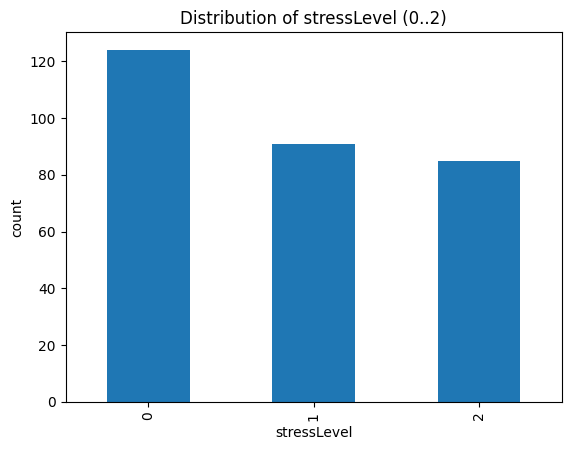


ROWS_PER_USER: {1: 60, 2: 60, 3: 60, 4: 60, 5: 60}


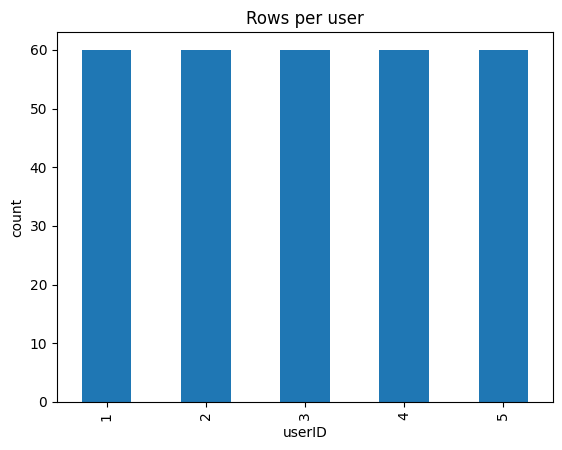

In [3]:
import matplotlib.pyplot as plt

# EDA QUICK CHECKS
target_counts = df[TARGET_COL].value_counts().sort_index()
print("TARGET_DIST (0..2):", target_counts.to_dict())

plt.figure()
target_counts.plot(kind="bar")
plt.title(f"Distribution of {TARGET_COL} (0..2)")
plt.xlabel(TARGET_COL)
plt.ylabel("count")
plt.show()

user_counts = df[USER_COL].value_counts()
print("\nROWS_PER_USER:", user_counts.to_dict())

plt.figure()
user_counts.sort_index().plot(kind="bar")
plt.title("Rows per user")
plt.xlabel(USER_COL)
plt.ylabel("count")
plt.show()


# Data Preprocessing

Tahap ini melakukan **feature engineering tanpa leakage**:
- Fitur kalender: `dow`, `is_weekend`
- Fitur lag target: `lag_sp_1..lag_sp_WINDOW`
- Rolling stats dari history yang berakhir di `t-1`
- (Opsional) `lag1_<behavior_col>` dari `t-1`

Transformasi label:
- `y_bin = 1` jika `stressLevel >= 1`
- `y_bin = 0` jika `stressLevel == 0`


In [4]:
# FEATURE ENGINEERING
rows = []
for uid, g in df.groupby(USER_COL):
    g = g.sort_values(DATE_COL).reset_index(drop=True)

    # Calendar features
    g["dow"] = g[DATE_COL].dt.dayofweek.astype(int)  # 0..6
    g["is_weekend"] = (g["dow"] >= 5).astype(int)

    # Target lag features (t-1..t-W)
    for k in range(1, WINDOW + 1):
        g[f"lag_sp_{k}"] = g[TARGET_COL].shift(k)

    # Behavior lag1 (t-1)
    if len(BEHAVIOR_COLS) > 0:
        for c in BEHAVIOR_COLS:
            g[f"lag1_{c}"] = g[c].shift(1)

    # Rolling stats from history ending at t-1
    sp_shift = g[TARGET_COL].shift(1)

    g["sp_mean"] = sp_shift.rolling(WINDOW).mean()
    g["sp_std"]  = sp_shift.rolling(WINDOW).std().fillna(0.0)
    g["sp_min"]  = sp_shift.rolling(WINDOW).min()
    g["sp_max"]  = sp_shift.rolling(WINDOW).max()

    g["count_high"] = (sp_shift >= 1).rolling(WINDOW).sum()
    g["count_low"]  = (sp_shift == 0).rolling(WINDOW).sum()

    # High streak (<= t-1)
    high = (sp_shift >= 1).astype(int).fillna(0).astype(int).tolist()
    streak, cur = [], 0
    for v in high:
        cur = cur + 1 if v == 1 else 0
        streak.append(cur)
    g["streak_high"] = streak

    # Transitions in history (<= t-1)
    diff = (sp_shift != sp_shift.shift(1)).astype(int)
    g["transitions"] = diff.rolling(WINDOW).sum()

    rows.append(g)

feat = pd.concat(rows, ignore_index=True)

# Binary labeling: y_bin = 1 if pred>=1 else 0
feat["y_bin"] = (feat[TARGET_COL] >= 1).astype(int)

# GLOBAL: never include USER_COL as a feature
feature_cols = (
    ["dow", "is_weekend"]
    + [f"lag_sp_{k}" for k in range(1, WINDOW + 1)]
    + [
        "sp_mean", "sp_std", "sp_min", "sp_max",
        "count_high", "count_low",
        "streak_high", "transitions",
    ]
)
if len(BEHAVIOR_COLS) > 0:
    feature_cols += [f"lag1_{c}" for c in BEHAVIOR_COLS]

# Drop rows without full history
feat = feat.dropna(subset=feature_cols + ["y_bin"]).reset_index(drop=True)

print("ROWS_FEAT      :", len(feat))
print("USERS_FEAT     :", feat[USER_COL].nunique())
print("FEATURES_COUNT :", len(feature_cols))
print("BINARY_DIST    :", feat["y_bin"].value_counts().to_dict())

display(feat[[USER_COL, DATE_COL, TARGET_COL, "y_bin"] + feature_cols].head())


ROWS_FEAT      : 285
USERS_FEAT     : 5
FEATURES_COUNT : 18
BINARY_DIST    : {1: 171, 0: 114}


,userID,date,stressLevel,y_bin,dow,is_weekend,lag_sp_1,lag_sp_2,lag_sp_3,sp_mean,...,sp_max,count_high,count_low,streak_high,transitions,lag1_extracurricularHourPerDay,lag1_physicalActivityHourPerDay,lag1_sleepHourPerDay,lag1_studyHourPerDay,lag1_socialHourPerDay
0,1,2025-11-24,1,1,0,0,0.0,0.0,1.0,0.333333,...,1.0,1.0,2.0,0,2.0,0.0,3.0,9.0,1.0,6.0
1,1,2025-11-25,1,1,1,0,1.0,0.0,0.0,0.333333,...,1.0,1.0,2.0,1,2.0,0.0,0.5,8.0,7.0,5.0
2,1,2025-11-26,1,1,2,0,1.0,1.0,0.0,0.666667,...,1.0,2.0,1.0,2,1.0,0.0,1.0,7.0,7.0,4.0
3,1,2025-11-27,1,1,3,0,1.0,1.0,1.0,1.000000,...,1.0,3.0,0.0,3,1.0,0.0,0.5,7.0,8.0,3.0
4,1,2025-11-28,1,1,4,0,1.0,1.0,1.0,1.000000,...,1.0,3.0,0.0,4,0.0,0.0,5.0,6.0,6.0,7.0


# Model Training and Evaluation

Cakupan:
1. Split time-based per user: `TEST = last TEST_LEN` per user  
2. Baseline L1 (Persistence): `y(t) = y(t-1)`  
3. Baseline L2 (Markov GLOBAL): `P(y_t | prev_high, dow)` + tuning threshold via pooled CV  
4. Model candidates (GLOBAL, tanpa userID) + fair pooled CV + threshold tuning  
5. (Opsional) BLEND: `p = alpha*p_ml + (1-alpha)*p_markov`  
6. Leaderboard + simpan artifact model terbaik


In [5]:
# SPLIT (TIME-BASED PER USER)
train_idx, test_idx = [], []
per_user_train_pool = {}

for uid, g in feat.groupby(USER_COL):
    g = g.sort_values(DATE_COL).reset_index()  # keeps original feat index in 'index'
    n = len(g)
    test_start = n - TEST_LEN
    if test_start <= 20:
        raise ValueError(f"User {uid} has too few rows for split+CV. n={n}, TEST_LEN={TEST_LEN}")

    train_pool = g.iloc[:test_start]
    test_block = g.iloc[test_start:]

    per_user_train_pool[uid] = train_pool
    train_idx += train_pool["index"].tolist()
    test_idx  += test_block["index"].tolist()

train_pool_df = feat.loc[train_idx].copy()
test_df = feat.loc[test_idx].copy()

print("TRAINPOOL_ROWS :", len(train_pool_df))
print("TEST_ROWS      :", len(test_df))
print("TEST_DIST      :", test_df["y_bin"].value_counts().to_dict())

# Build pooled CV splits from windows inside each user's train_pool
cv_splits = []
for (v0, v1) in VAL_WINDOWS:
    tr_idx, va_idx = [], []
    ok = True
    for uid, tp in per_user_train_pool.items():
        tp = tp.reset_index(drop=True)
        if len(tp) < v1:
            ok = False
            break
        va = tp.iloc[v0:v1]
        tr = tp.iloc[:v0]
        tr_idx += tr["index"].tolist()
        va_idx += va["index"].tolist()
    if ok:
        cv_splits.append((tr_idx, va_idx))

if len(cv_splits) == 0:
    raise ValueError("CV windows cannot be formed. Reduce TEST_LEN or adjust VAL_WINDOWS.")

print("CV_FOLDS     :", len(cv_splits))
print("VAL_WINDOWS  :", VAL_WINDOWS)

X_trainpool = train_pool_df[feature_cols].copy()
y_trainpool = train_pool_df["y_bin"].astype(int).values

X_test = test_df[feature_cols].copy()
y_test = test_df["y_bin"].astype(int).values


TRAINPOOL_ROWS : 225
TEST_ROWS      : 60
TEST_DIST      : {1: 49, 0: 11}
CV_FOLDS     : 2
VAL_WINDOWS  : [(12, 24), (18, 30)]


In [6]:
# BASELINE L1: PERSISTENCE (y(t)=y(t-1))
pred_persist = (test_df["lag_sp_1"] >= 1).astype(int).values
persist_metrics = eval_bin(y_test, pred_persist)

print("TEST_ACC :", persist_metrics["acc"])
print("TEST_F1  :", persist_metrics["f1"])


TEST_ACC : 0.8
TEST_F1  : 0.8775510204081632


In [7]:
# BASELINE L2: MARKOV GLOBAL (prev_high, dow) + THR TUNING (POOLED CV)
def train_markov_global(df_train):
    # counts: prev(2) x dow(7) x y(2)
    counts = np.zeros((2, 7, 2), dtype=int)
    prev = (df_train["lag_sp_1"] >= 1).astype(int).values
    dow  = df_train["dow"].astype(int).values
    yb   = df_train["y_bin"].astype(int).values
    for p, d, y in zip(prev, dow, yb):
        counts[p, d, y] += 1
    # Laplace smoothing
    probs = (counts + 1) / (counts.sum(axis=2, keepdims=True) + 2)
    return probs

def markov_proba(probs, df_eval):
    prev = (df_eval["lag_sp_1"] >= 1).astype(int).values
    dow  = df_eval["dow"].astype(int).values
    return np.array([probs[p, d, 1] for p, d in zip(prev, dow)], dtype=float)

# Threshold tuning on pooled CV (no leakage)
cv_true, cv_phigh = [], []
for _, (tr_idx, va_idx) in enumerate(cv_splits, start=1):
    tr_df = feat.loc[tr_idx]
    va_df = feat.loc[va_idx]
    probs = train_markov_global(tr_df)
    p = markov_proba(probs, va_df)
    cv_true.append(va_df["y_bin"].astype(int).values)
    cv_phigh.append(p)

cv_true = np.concatenate(cv_true)
cv_phigh = np.concatenate(cv_phigh)

thr_mk, cv_f1_mk = tune_thr_from_proba(cv_true, cv_phigh)

# Train Markov on full train_pool and evaluate on test
probs_full = train_markov_global(train_pool_df)
p_test_mk = markov_proba(probs_full, test_df)
pred_test_mk = (p_test_mk >= thr_mk).astype(int)
markov_metrics = eval_bin(y_test, pred_test_mk)

print("CV_POOLED_DIST  :", safe_class_counts(cv_true))
print("BEST_THR_MARKOV :", thr_mk)
print("CV_POOLED_F1    :", cv_f1_mk)
print("TEST_ACC_MARKOV :", markov_metrics["acc"])
print("TEST_F1_MARKOV  :", markov_metrics["f1"])


CV_POOLED_DIST  : {0: 34, 1: 86}
BEST_THR_MARKOV : 0.35
CV_POOLED_F1    : 0.8522727272727273
TEST_ACC_MARKOV : 0.85
TEST_F1_MARKOV  : 0.9108910891089109


In [8]:
# PREPROCESS (GLOBAL: NO userID)
cat_cols = ["dow"]
num_cols = [c for c in feature_cols if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), num_cols),
    ],
    remainder="drop",
)


In [9]:
# CANDIDATE MODELS
CANDIDATES = {
    "LogReg": (
        LogisticRegression(max_iter=5000, class_weight="balanced", random_state=RANDOM_STATE),
        {"clf__C": [0.03, 0.1, 0.3, 1.0, 3.0], "clf__solver": ["liblinear"]},
    ),
    "DecisionTree": (
        DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE),
        {"clf__max_depth": [2, 3, 4, 6, None], "clf__min_samples_leaf": [1, 2, 4, 8]},
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1),
        {"clf__n_estimators": [200, 400, 800], "clf__max_depth": [None, 6, 10],
         "clf__min_samples_leaf": [1, 2, 4], "clf__max_features": ["sqrt"]},
    ),
    "ExtraTrees": (
        ExtraTreesClassifier(class_weight="balanced", random_state=RANDOM_STATE, n_jobs=1),
        {"clf__n_estimators": [200, 400, 800], "clf__max_depth": [None, 6, 10],
         "clf__min_samples_leaf": [1, 2, 4], "clf__max_features": ["sqrt"]},
    ),
    "HistGB": (
        HistGradientBoostingClassifier(random_state=RANDOM_STATE),
        {"clf__learning_rate": [0.03, 0.05, 0.1], "clf__max_depth": [2, 3], "clf__max_leaf_nodes": [15, 31, 63]},
    ),
    "GradBoost": (
        GradientBoostingClassifier(random_state=RANDOM_STATE),
        {"clf__learning_rate": [0.03, 0.05, 0.1], "clf__n_estimators": [100, 200, 400], "clf__max_depth": [2, 3]},
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=RANDOM_STATE),
        {"clf__learning_rate": [0.03, 0.05, 0.1, 0.3], "clf__n_estimators": [50, 100, 200, 400]},
    ),
    "BaggingTree": (
        BaggingClassifier(
            estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
            random_state=RANDOM_STATE,
            n_jobs=1,
        ),
        {"clf__n_estimators": [50, 100, 200],
         "clf__estimator__max_depth": [2, 3, 4, None],
         "clf__estimator__min_samples_leaf": [1, 2, 4]},
    ),
    "LinearSVC_Calibrated": (
        CalibratedClassifierCV(
            estimator=LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
            method="sigmoid",
            cv=3,
        ),
        {"clf__estimator__C": [0.03, 0.1, 0.3, 1.0, 3.0]},
    ),
}

print("MODELS     :", list(CANDIDATES.keys()))
print("USE_BLEND  :", USE_BLEND)
print("ALPHAS     :", ALPHAS.tolist())
print("THRESHOLDS :", THRESHOLDS.tolist())


MODELS     : ['LogReg', 'DecisionTree', 'RandomForest', 'ExtraTrees', 'HistGB', 'GradBoost', 'AdaBoost', 'BaggingTree', 'LinearSVC_Calibrated']
USE_BLEND  : True
ALPHAS     : [0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 1.0]
THRESHOLDS : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95]


In [10]:
# TRAIN + TUNE (FAIR POOLED CV)
def make_pipe(clf):
    return Pipeline([("prep", preprocess), ("clf", clf)])

def make_calibrated_svc(cv_k: int):
    return CalibratedClassifierCV(
        estimator=LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
        method="sigmoid",
        cv=cv_k,
    )

def pooled_cv_best(model_name: str, base_clf, grid):
    best = None

    for params in ParameterGrid(grid):
        y_list, pml_list, pmk_list = [], [], []
        valid_folds = 0

        for (tr_idx, va_idx) in cv_splits:
            tr_df = feat.loc[tr_idx]
            va_df = feat.loc[va_idx]

            Xtr = tr_df[feature_cols].copy()
            ytr = tr_df["y_bin"].astype(int).values
            Xva = va_df[feature_cols].copy()
            yva = va_df["y_bin"].astype(int).values

            if len(np.unique(ytr)) < 2:
                continue

            mk_probs = train_markov_global(tr_df)
            p_mk = markov_proba(mk_probs, va_df)

            try:
                if model_name == "LinearSVC_Calibrated":
                    counts = safe_class_counts(ytr)
                    min_class = min(counts.values())
                    cv_k = int(min(3, min_class))
                    if cv_k < 2:
                        continue
                    clf = make_calibrated_svc(cv_k=cv_k)
                    pipe = make_pipe(clf)
                else:
                    pipe = make_pipe(base_clf)

                pipe.set_params(**params)
                pipe.fit(Xtr, ytr)
                p_ml = pipe.predict_proba(Xva)[:, 1]
            except Exception:
                valid_folds = 0
                break

            y_list.append(yva)
            pml_list.append(p_ml)
            pmk_list.append(p_mk)
            valid_folds += 1

        if valid_folds == 0:
            continue

        y_all = np.concatenate(y_list)
        pml_all = np.concatenate(pml_list)
        pmk_all = np.concatenate(pmk_list)

        if USE_BLEND:
            local_best = None
            for alpha in ALPHAS:
                p_blend = alpha * pml_all + (1.0 - alpha) * pmk_all
                thr, cv_f1 = tune_thr_from_proba(y_all, p_blend)
                if (local_best is None) or (cv_f1 > local_best["cv_f1"]):
                    local_best = {"alpha": float(alpha), "thr": float(thr), "cv_f1": float(cv_f1)}
            record = {"params": params, **local_best, "valid_folds": int(valid_folds)}
        else:
            thr, cv_f1 = tune_thr_from_proba(y_all, pml_all)
            record = {"params": params, "alpha": 1.0, "thr": float(thr), "cv_f1": float(cv_f1), "valid_folds": int(valid_folds)}

        if (best is None) or (record["cv_f1"] > best["cv_f1"]):
            best = record

    return best


rows = []
for model_name, (clf, grid) in CANDIDATES.items():
    best = pooled_cv_best(model_name, clf, grid)
    if best is None:
        print("SKIP_MODEL :", model_name, "(no valid params/folds)")
        continue

    try:
        if model_name == "LinearSVC_Calibrated":
            counts = safe_class_counts(y_trainpool)
            min_class = min(counts.values())
            cv_k = int(min(3, min_class))
            if cv_k < 2:
                raise ValueError("TrainPool is too small for calibrated SVC (cv_k < 2).")
            final_clf = make_calibrated_svc(cv_k=cv_k)
        else:
            final_clf = clf

        final_pipe = make_pipe(final_clf)
        final_pipe.set_params(**best["params"])
        final_pipe.fit(X_trainpool, y_trainpool)
        p_test_ml = final_pipe.predict_proba(X_test)[:, 1]
    except Exception:
        print("SKIP_MODEL :", model_name, "(failed final training)")
        continue

    p_test_mk_full = markov_proba(probs_full, test_df)

    alpha = float(best["alpha"])
    p_test_final = alpha * p_test_ml + (1.0 - alpha) * p_test_mk_full
    pred_test_final = (p_test_final >= best["thr"]).astype(int)

    test_metrics = eval_bin(y_test, pred_test_final)

    rows.append({
        "model": model_name,
        "cv_f1": float(best["cv_f1"]),
        "alpha": float(best["alpha"]),
        "thr": float(best["thr"]),
        "valid_folds": int(best["valid_folds"]),
        "test_f1": float(test_metrics["f1"]),
        "test_acc": float(test_metrics["acc"]),
        "params": dict(best["params"]),
        "pipe": final_pipe,
    })

    print("MODEL        :", model_name)
    print("  CV_F1      :", float(best["cv_f1"]))
    print("  VALID_FOLDS:", int(best["valid_folds"]))
    print("  ALPHA      :", float(best["alpha"]))
    print("  THR        :", float(best["thr"]))
    print("  TEST_F1    :", float(test_metrics["f1"]))
    print("  TEST_ACC   :", float(test_metrics["acc"]))
    print("  PARAMS     :", dict(best["params"]))


MODEL        : LogReg
  CV_F1      : 0.861878453038674
  VALID_FOLDS: 2
  ALPHA      : 0.30000000000000004
  THR        : 0.35
  TEST_F1    : 0.9019607843137255
  TEST_ACC   : 0.8333333333333334
  PARAMS     : {'clf__C': 0.03, 'clf__solver': 'liblinear'}
MODEL        : DecisionTree
  CV_F1      : 0.865979381443299
  VALID_FOLDS: 2
  ALPHA      : 0.7000000000000001
  THR        : 0.1
  TEST_F1    : 0.8990825688073395
  TEST_ACC   : 0.8166666666666667
  PARAMS     : {'clf__max_depth': 3, 'clf__min_samples_leaf': 4}
MODEL        : RandomForest
  CV_F1      : 0.8677248677248677
  VALID_FOLDS: 2
  ALPHA      : 0.8
  THR        : 0.39999999999999997
  TEST_F1    : 0.9230769230769231
  TEST_ACC   : 0.8666666666666667
  PARAMS     : {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 400}
MODEL        : ExtraTrees
  CV_F1      : 0.8587570621468926
  VALID_FOLDS: 2
  ALPHA      : 0.30000000000000004
  THR        : 0.39999999999999997
  TEST_F1 

In [11]:
# LEADERBOARD + SELECT BEST
base_rows = [
    {"model": "Baseline-Persist", "cv_f1": np.nan, "alpha": np.nan, "thr": np.nan,
     "test_f1": persist_metrics["f1"], "test_acc": persist_metrics["acc"], "params": None},
    {"model": "Baseline-Markov",  "cv_f1": cv_f1_mk, "alpha": 0.0, "thr": thr_mk,
     "test_f1": markov_metrics["f1"], "test_acc": markov_metrics["acc"], "params": {"markov": "prev_high+dow"}},
]

all_rows = base_rows + [{k: v for k, v in r.items() if k != "pipe"} for r in rows]
all_sorted = sorted(all_rows, key=lambda r: r["test_f1"], reverse=True)

for r in all_sorted:
    print(
        "MODEL=", r["model"],
        "| CV_F1=", r["cv_f1"],
        "| TEST_F1=", r["test_f1"],
        "| TEST_ACC=", r["test_acc"],
        "| ALPHA=", r["alpha"],
        "| THR=", r["thr"],
        "| PARAMS=", r["params"]
    )

if len(rows) == 0:
    print("\nRESULT: No valid ML model. Saving Markov as best.")
    best_name = "MarkovGlobal"
    best_obj = {
        "type": "global_markov",
        "thr": float(thr_mk),
        "probs": probs_full,
        "meta": {
            "note": "No ML model succeeded; Markov saved as best",
            "target": "y_bin=(stressLevel>=1)",
            "date_col": DATE_COL,
            "user_col": USER_COL,
            "target_col": TARGET_COL,
            "window": WINDOW,
            "test_len": TEST_LEN,
            "val_windows": VAL_WINDOWS,
            "thresholds": THRESHOLDS.tolist(),
            "use_blend": USE_BLEND,
            "alphas": ALPHAS.tolist(),
            "behavior_cols": BEHAVIOR_COLS,
            "feature_cols": feature_cols,
        },
    }
else:
    best_ml = sorted(rows, key=lambda r: r["test_f1"], reverse=True)[0]

    print("\nRESULT")
    print("BEST_ML_MODEL   :", best_ml["model"])
    print("BEST_ML_TEST_F1 :", best_ml["test_f1"])
    print("BEST_ML_TEST_ACC:", best_ml["test_acc"])
    print("BEST_ML_ALPHA   :", best_ml["alpha"])
    print("BEST_ML_THR     :", best_ml["thr"])
    print("BEST_ML_PARAMS  :", best_ml["params"])

    if best_ml["test_f1"] > markov_metrics["f1"]:
        best_name = best_ml["model"]
        best_obj = {
            "type": "global_blend_model" if USE_BLEND else "global_ml_model",
            "pipe": best_ml["pipe"],
            "alpha": float(best_ml["alpha"]),
            "thr": float(best_ml["thr"]),
            "markov_probs": probs_full,
            "meta": {
                "note": "GLOBAL (no userID). Uses p = alpha*p_ml + (1-alpha)*p_markov" if USE_BLEND else "GLOBAL (no userID). Uses ML prob only",
                "target": "y_bin=(stressLevel>=1)",
                "date_col": DATE_COL,
                "user_col": USER_COL,
                "target_col": TARGET_COL,
                "window": WINDOW,
                "test_len": TEST_LEN,
                "val_windows": VAL_WINDOWS,
                "thresholds": THRESHOLDS.tolist(),
                "use_blend": USE_BLEND,
                "alphas": ALPHAS.tolist(),
                "behavior_cols": BEHAVIOR_COLS,
                "feature_cols": feature_cols,
            },
        }
        print("SELECTED_BEST   : ML/BLEND (beats Markov on TEST)")
    else:
        best_name = "MarkovGlobal"
        best_obj = {
            "type": "global_markov",
            "thr": float(thr_mk),
            "probs": probs_full,
            "meta": {
                "note": "Markov remains best on TEST for this dataset",
                "target": "y_bin=(stressLevel>=1)",
                "date_col": DATE_COL,
                "user_col": USER_COL,
                "target_col": TARGET_COL,
                "window": WINDOW,
                "test_len": TEST_LEN,
                "val_windows": VAL_WINDOWS,
                "thresholds": THRESHOLDS.tolist(),
                "use_blend": USE_BLEND,
                "alphas": ALPHAS.tolist(),
                "behavior_cols": BEHAVIOR_COLS,
                "feature_cols": feature_cols,
            },
        }
        print("SELECTED_BEST   : MARKOV (still best on TEST)")


MODEL= BaggingTree | CV_F1= 0.861878453038674 | TEST_F1= 0.9333333333333333 | TEST_ACC= 0.8833333333333333 | ALPHA= 0.30000000000000004 | THR= 0.3 | PARAMS= {'clf__estimator__max_depth': 3, 'clf__estimator__min_samples_leaf': 1, 'clf__n_estimators': 50}
MODEL= RandomForest | CV_F1= 0.8677248677248677 | TEST_F1= 0.9230769230769231 | TEST_ACC= 0.8666666666666667 | ALPHA= 0.8 | THR= 0.39999999999999997 | PARAMS= {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 400}
MODEL= Baseline-Markov | CV_F1= 0.8522727272727273 | TEST_F1= 0.9108910891089109 | TEST_ACC= 0.85 | ALPHA= 0.0 | THR= 0.35 | PARAMS= {'markov': 'prev_high+dow'}
MODEL= AdaBoost | CV_F1= 0.861878453038674 | TEST_F1= 0.9108910891089109 | TEST_ACC= 0.85 | ALPHA= 0.2 | THR= 0.35 | PARAMS= {'clf__learning_rate': 0.3, 'clf__n_estimators': 100}
MODEL= LogReg | CV_F1= 0.861878453038674 | TEST_F1= 0.9019607843137255 | TEST_ACC= 0.8333333333333334 | ALPHA= 0.30000000000000004 | THR= 0

In [12]:
# SAVE MODEL ARTIFACT
MODEL_OUT.parent.mkdir(parents=True, exist_ok=True)
joblib.dump(best_obj, MODEL_OUT)

print("SAVED_TO  :", str(MODEL_OUT))
print("BEST_NAME :", best_name)
print("BEST_TYPE :", best_obj["type"])


SAVED_TO  : ..\models\global_forecast.joblib
BEST_NAME : BaggingTree
BEST_TYPE : global_blend_model


# Try Model

Bagian ini digunakan untuk melakukan uji inference menggunakan artifact yang sudah tersimpan, tanpa menjalankan proses training ulang.

Output yang ditampilkan:
- Prediksi `y_bin` dan probabilitas akhir (`p_final`) untuk baris terbaru tiap `userID`
- Metrik cepat pada sampel tersebut (Accuracy dan F1)


In [13]:
# TRY MODEL
import numpy as np
import pandas as pd
from pathlib import Path
import joblib
from IPython.display import display
from sklearn.metrics import accuracy_score, f1_score

# Artifact path (update if needed)
ARTIFACT_PATH = Path("../models/global_forecast.joblib")
if not ARTIFACT_PATH.exists():
    raise FileNotFoundError(f"Model artifact not found: {ARTIFACT_PATH}")

# Dataset paths
CANDIDATE_DATA_PATHS = [
    Path("../datasets/stress_forecast.csv"),
]
DATA_PATH = next((p for p in CANDIDATE_DATA_PATHS if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError("Dataset not found. Check CANDIDATE_DATA_PATHS.")

# Load artifact
artifact = joblib.load(ARTIFACT_PATH)
meta = artifact.get("meta", {})

DATE_COL = meta.get("date_col", "date")
USER_COL = meta.get("user_col", "userID")
TARGET_COL = meta.get("target_col", "stressLevel")
WINDOW = int(meta.get("window", 3))

feature_cols = meta.get("feature_cols")
behavior_cols = meta.get("behavior_cols", [])

# Load dataset
df = pd.read_csv(DATA_PATH)
for col in [DATE_COL, USER_COL, TARGET_COL]:
    if col not in df.columns:
        raise KeyError(f"Required column '{col}' not found in dataset.")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="raise")
df = df.sort_values([USER_COL, DATE_COL]).reset_index(drop=True)

# Feature engineering (no-leak, aligned with training pipeline)
rows = []
for uid, g in df.groupby(USER_COL):
    g = g.sort_values(DATE_COL).reset_index(drop=True)

    g["dow"] = g[DATE_COL].dt.dayofweek.astype(int)
    g["is_weekend"] = (g["dow"] >= 5).astype(int)

    for k in range(1, WINDOW + 1):
        g[f"lag_sp_{k}"] = g[TARGET_COL].shift(k)

    if isinstance(behavior_cols, (list, tuple)):
        for c in behavior_cols:
            if c in g.columns:
                g[f"lag1_{c}"] = g[c].shift(1)

    sp_shift = g[TARGET_COL].shift(1)

    g["sp_mean"] = sp_shift.rolling(WINDOW).mean()
    g["sp_std"]  = sp_shift.rolling(WINDOW).std().fillna(0.0)
    g["sp_min"]  = sp_shift.rolling(WINDOW).min()
    g["sp_max"]  = sp_shift.rolling(WINDOW).max()

    g["count_high"] = (sp_shift >= 1).rolling(WINDOW).sum()
    g["count_low"]  = (sp_shift == 0).rolling(WINDOW).sum()

    high = (sp_shift >= 1).astype(int).fillna(0).astype(int).tolist()
    streak, cur = [], 0
    for v in high:
        cur = cur + 1 if v == 1 else 0
        streak.append(cur)
    g["streak_high"] = streak

    diff = (sp_shift != sp_shift.shift(1)).astype(int)
    g["transitions"] = diff.rolling(WINDOW).sum()

    rows.append(g)

feat = pd.concat(rows, ignore_index=True)
feat["y_bin"] = (feat[TARGET_COL] >= 1).astype(int)

# If feature_cols is missing in artifact, reconstruct a compatible list
if not isinstance(feature_cols, (list, tuple)) or len(feature_cols) == 0:
    feature_cols = (
        ["dow", "is_weekend"]
        + [f"lag_sp_{k}" for k in range(1, WINDOW + 1)]
        + [
            "sp_mean", "sp_std", "sp_min", "sp_max",
            "count_high", "count_low",
            "streak_high", "transitions",
        ]
    )
    if isinstance(behavior_cols, (list, tuple)):
        for c in behavior_cols:
            if c in df.columns:
                feature_cols.append(f"lag1_{c}")

missing_cols = [c for c in feature_cols if c not in feat.columns]
if len(missing_cols) > 0:
    raise KeyError(f"Engineered feature columns missing: {missing_cols}")

feat = feat.dropna(subset=feature_cols + ["y_bin"]).reset_index(drop=True)

# Latest available row per user
sample_df = (
    feat.sort_values([USER_COL, DATE_COL])
        .groupby(USER_COL, as_index=False)
        .tail(1)
        .reset_index(drop=True)
)

def markov_proba(probs, df_eval):
    prev = (df_eval["lag_sp_1"] >= 1).astype(int).values
    dow  = df_eval["dow"].astype(int).values
    return np.array([probs[p, d, 1] for p, d in zip(prev, dow)], dtype=float)

def predict_with_artifact(artifact_obj, df_feat_rows, feature_cols_local):
    art_type = artifact_obj.get("type", "")

    if art_type == "global_markov":
        thr = float(artifact_obj["thr"])
        probs = artifact_obj["probs"]
        p_mk = markov_proba(probs, df_feat_rows)
        pred = (p_mk >= thr).astype(int)
        return p_mk, pred

    if art_type in ["global_blend_model", "global_ml_model"]:
        thr = float(artifact_obj["thr"])
        pipe = artifact_obj["pipe"]
        p_ml = pipe.predict_proba(df_feat_rows[feature_cols_local])[:, 1]

        if art_type == "global_ml_model":
            p_final = p_ml
            pred = (p_final >= thr).astype(int)
            return p_final, pred

        alpha = float(artifact_obj["alpha"])
        probs = artifact_obj["markov_probs"]
        p_mk = markov_proba(probs, df_feat_rows)

        p_final = alpha * p_ml + (1.0 - alpha) * p_mk
        pred = (p_final >= thr).astype(int)
        return p_final, pred

    raise ValueError(f"Unknown artifact type: {art_type}")

p_final, pred = predict_with_artifact(artifact, sample_df, feature_cols)

out = sample_df[[USER_COL, DATE_COL, TARGET_COL, "y_bin"]].copy()
out["p_final"] = p_final
out["pred"] = pred
out = out.sort_values([USER_COL]).reset_index(drop=True)

print("ARTIFACT_TYPE:", artifact.get("type"))
print("ARTIFACT_PATH:", str(ARTIFACT_PATH))
print("DATA_PATH    :", str(DATA_PATH))

display(out)

print("\nMETRICS ON SAMPLE (LAST ROW PER USER):")
print("ACC:", float(accuracy_score(out["y_bin"].values, out["pred"].values)))
print("F1 :", float(f1_score(out["y_bin"].values, out["pred"].values, zero_division=0)))


ARTIFACT_TYPE: global_blend_model
ARTIFACT_PATH: ..\models\global_forecast.joblib
DATA_PATH    : ..\datasets\stress_forecast.csv


,userID,date,stressLevel,y_bin,p_final,pred
0,1,2026-01-19,2,1,0.903558,1
1,2,2026-01-19,2,1,0.897538,1
2,3,2026-01-19,2,1,0.901433,1
3,4,2026-01-19,2,1,0.855993,1
4,5,2026-01-19,2,1,0.898970,1



METRICS ON SAMPLE (LAST ROW PER USER):
ACC: 1.0
F1 : 1.0
